In [1]:
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax, discreteProb
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from my_gym.envs.maze_mdp import MazeMDPEnv

import gym
import my_gym
from IPython.display import Video

from mazemdp import random_policy

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
  os.mkdir("./videos")

# Settings
NB_EPISODES = 50
TIMEOUT = 25
MAZE_SIZE = 10
MAZE_RATIO = 0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/my_gym to /tmp/pip-req-build-vto59goz
  Running command git clone -q https://github.com/osigaud/my_gym /tmp/pip-req-build-vto59goz
     |████████████████████████████████| 1.5 MB 22.4 MB/s 
     |████████████████████████████████| 1.3 MB 56.9 MB/s 
  Created wheel for bbrl-gym: filename=bbrl_gym-0.1.0-py3-none-any.whl size=17222 sha256=1eeff05c4bbbdd7075f2574f3001917c42387fcaae45b78df097ba22dd507968
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbho3q2f/wheels/0b/2c/67/5df37c12451553731420023ff73d12effcae27a38cc5053550
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=823773ddbb1d57a61a636d4b88388bdbb01ed8bb052706cb77f85e098156b8c0
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for mazemdp: filename=mazemdp-0.1.1-py3-none-any.whl size=14721 sha

In [2]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": MAZE_SIZE, "height": MAZE_SIZE, "ratio": MAZE_RATIO})
env.reset()
env.init_draw("The maze")

Output()

In [3]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

def actor_critic(
    mdp: MazeMDPEnv,
    nb_episodes:int,
    timeout:int,
    alpha_critic:float,
    alpha_actor:float,
    render:bool
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.ones((mdp.nb_states, mdp.action_space.size)) / mdp.action_space.size
    v = np.zeros(mdp.nb_states)
    n_update = 0

    q0 = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Actor-Critic")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)
        done = False
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw the max action from q table
            a = np.random.choice([
                i for i in range(len(q[s,:])) if q[s,i] == np.max(q[s,:])
            ])

            # Perform a step of the MDP
            y, r, done, _ = mdp.step(a)

            # Update critic
            delta = r + mdp.gamma * (v[y] - v[s])
            v[s] += alpha_critic * delta

            # Update actor
            q[s,a] += alpha_actor * delta

            # Normalize q so it's still probabilities
            q[s,a] /= np.sum(q[s,])

            # Update logs
            n_update += 1

            # Update the agent position
            s = y
        q_list.append(np.linalg.norm(np.maximum(q, q0)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Actor-Critic")
    return q, q_list, n_update

In [4]:
# Create maze environment
env = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": MAZE_RATIO})
env.reset()
# env.init_draw("The maze")

alpha_critic = 0.2
alpha_actor = 0.1
q, q_list, _ = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=False)

In [49]:
import time

param_critic = np.arange(0.1, 2, 0.05)
param_actor = np.arange(0.1, 1.3, 0.05)
n_simulation = 10

# param_critic = np.arange(0.1, 1, 0.3)
# param_actor = np.arange(0.1, 1, 0.3)
# n_simulation = 1

time_tab = []
n_update_tab = []
q_list_tab = []

for alpha_critic in tqdm(param_critic):
  for alpha_actor in param_actor:
    time_taken = 0
    n_update = 0
    for _ in range(n_simulation):
      start = time.time()
      _, q_list, n = actor_critic(env, nb_episodes=NB_EPISODES, timeout=TIMEOUT, alpha_critic=alpha_critic, alpha_actor=alpha_actor, render=False)
      time_taken += time.time() - start
      n_update += n
    q_list_tab.append(q_list)
    time_tab.append(time_taken/n_simulation)
    n_update_tab.append(n_update/n_simulation)

time_tab = np.array(time_tab)
n_update_tab = np.array(n_update_tab)
q_list_tab = np.array(q_list_tab)

  0%|          | 0/38 [00:00<?, ?it/s]

In [50]:
print((time_tab).shape)
print((n_update_tab).shape)
print((q_list_tab).shape)

(912,)
(912,)
(912, 50)


In [51]:
time_tab_2d = time_tab.reshape(param_actor.shape[0], param_critic.shape[0])
n_update_tab_2d = n_update_tab.reshape(param_actor.shape[0], param_critic.shape[0])
q_list_tab_2d = q_list_tab.reshape(param_actor.shape[0], param_critic.shape[0], -1)

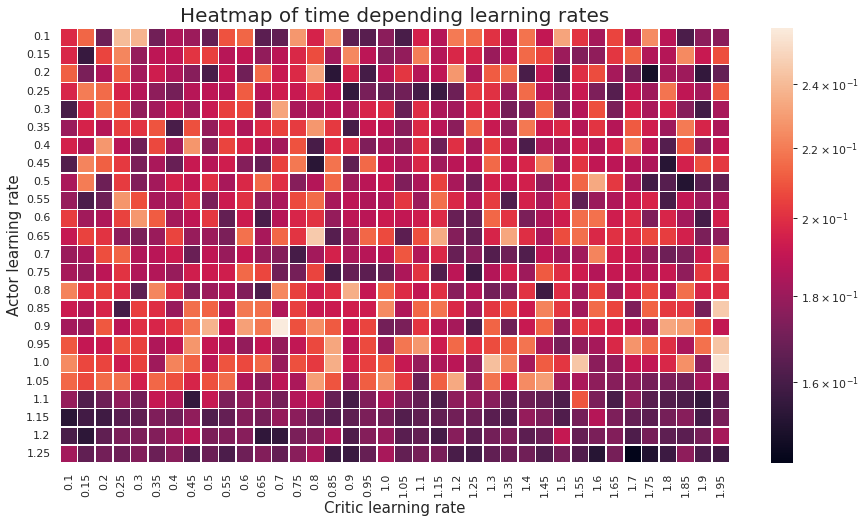

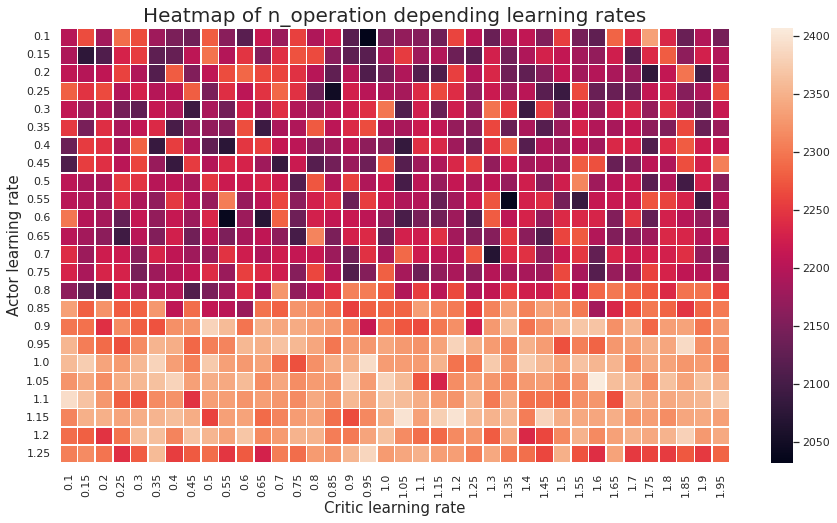

In [52]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(time_tab_2d, linewidth=0.5, xticklabels=np.around(param_critic, 2), yticklabels=np.around(param_actor, 2), norm=LogNorm())
plt.title('Heatmap of time depending learning rates', fontsize=20)
plt.xlabel('Critic learning rate', fontsize=15)
plt.ylabel('Actor learning rate', fontsize=15)
plt.show()

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(n_update_tab_2d, linewidth=0.5, xticklabels=np.around(param_critic, 2), yticklabels=np.around(param_actor, 2))
plt.title('Heatmap of n_operation depending learning rates', fontsize=20)
plt.xlabel('Critic learning rate', fontsize=15)
plt.ylabel('Actor learning rate', fontsize=15)
plt.show()

In [1]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(n_update_tab_2d.sum(axis=1), linewidth=0.5, xticklabels=np.around(param_actor, 2))
plt.title('Heatmap of n_operation depending actor learning rate', fontsize=20)
plt.ylabel('Actor learning rate', fontsize=15)
plt.show()

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(n_update_tab_2d.sum(axis=0), linewidth=0.5, xticklabels=np.around(param_critic, 2))
plt.title('Heatmap of n_operation depending critic learning rate', fontsize=20)
plt.xlabel('Critic learning rate', fontsize=15)
plt.show()

NameError: ignored

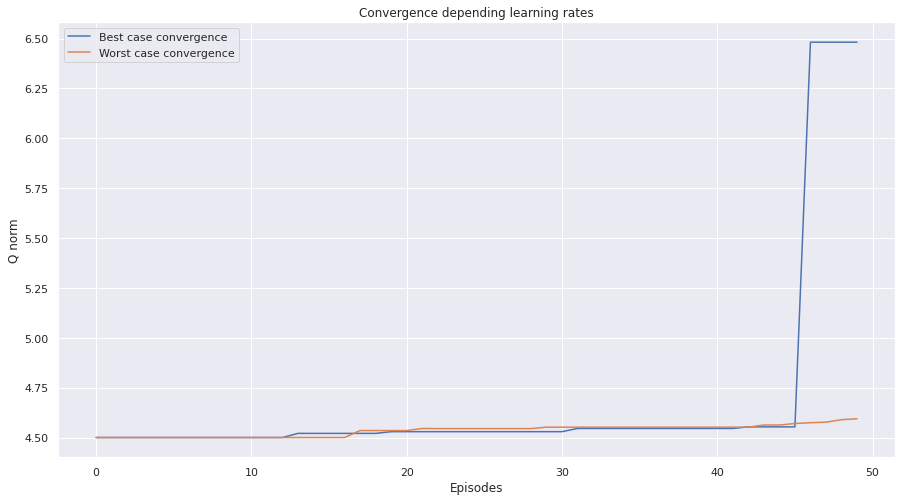

In [53]:
# test_critic = 0
# test_actor = 0
# print(q_list_tab_2d[test_critic, test_actor])
# print(param_critic[test_critic])
# print(param_actor[test_actor])

worst_critic, worst_actor = np.unravel_index(np.argmin(n_update_tab_2d, axis=None), n_update_tab_2d.shape)
best_critic, best_actor = np.unravel_index(np.argmax(n_update_tab_2d, axis=None), n_update_tab_2d.shape)

plt.plot(q_list_tab_2d[best_critic, best_actor], label="Best case convergence")
plt.plot(q_list_tab_2d[worst_critic, worst_actor], label="Worst case convergence")
plt.xlabel("Episodes")
plt.ylabel("Q norm")
plt.legend(loc='upper left')
plt.title("Convergence depending learning rates")
plt.show()

In [54]:
# The mini-project consists in coding a naive actor-critic algorithm and looking for the adequate policy and critic learning rates to 
# converge as fast as possible on a set of 10x10 mazes. The global report should contain your actor-critic code, the values of 
# hyper-parameters you used, and a set of learning curves highlighting the learning behavior of your algorithm, with a short discussion of your results.

# Thanks to the heatmap we can see that the optimal parameters for this environment (maze 10x10) are around alpha_critic=?? and alpha_actor=??
# Most of the optimal pairs of learning rates confirm that the critic learning rate should be superior to the actor learning rate

# To get better estimation of those parameters, we perform multiple simulation with the same pair of parameters, then we take the mean time
# We also use the same random seed

# Now we can look at the learning by watching the Q norm with and without optimal learning rates. As we can see on the plot, the best parameters
# according to the number of operation builds fast converging q values. While we can see it is kind of diverging for the worst parameters.